# Final RL Project - DEEP Reinforcements Learning in MultiRoom Environment

Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---

Name and ID:  
Student 1: 204266191
<br>
Student 2: 318947470
<br><br>


## Pre-Requisit


### Imports


In [10]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import cv2
print("Global dependencies loaded successfully")

Global dependencies loaded successfully


In [29]:
# our project imports
from minigrid.envs import MultiRoomEnv
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt
import sys
import tqdm
from cv2 import cvtColor
from pathlib import Path
from abc import ABC, abstractmethod

print("Local dependencies loaded successfully")


Local dependencies loaded successfully


In [12]:

import display_functions
import env_functions
from display_functions import show_full_frame_rgb, show_partial_greyscale, show_state_full_and_partial
from env_functions import create_multiroom_env, get_action_meaning

In [13]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"
WORK_DIR = Path("C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project")

### Display utils

The cell below contains the video display configuration. No need to make changes here.


In [14]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

# display = pyvirtualdisplay.Display(visible=0, size=(1400, 900), backend=None).start()

## Introduction

A
For this project, you will work with environments from the [MiniGrid](https://minigrid.farama.org) framework. MiniGrid is designed to test and benchmark reinforcement learning algorithms, offering a diverse range of tasks with varying levels of complexity.

MiniGrid environments are built around the concept of a partially observable, grid-based world where an agent operates to achieve predefined objectives.

### **MultiRoom Environment**

You will work with the **MultiRoom Environment** see docomentation [here](https://minigrid.farama.org/environments/minigrid/MultiRoomEnv/). MultiRoomEnv introduces a level of complexity beyond simple navigation tasks by requiring the agent to navigate through multiple connected rooms to reach a goal. This environment is an excellent testbed for reinforcement learning algorithms that require exploration, memory, and planning.

### Wrapper Usage

To apply a wrapper, you can modify your environment setup as follows:


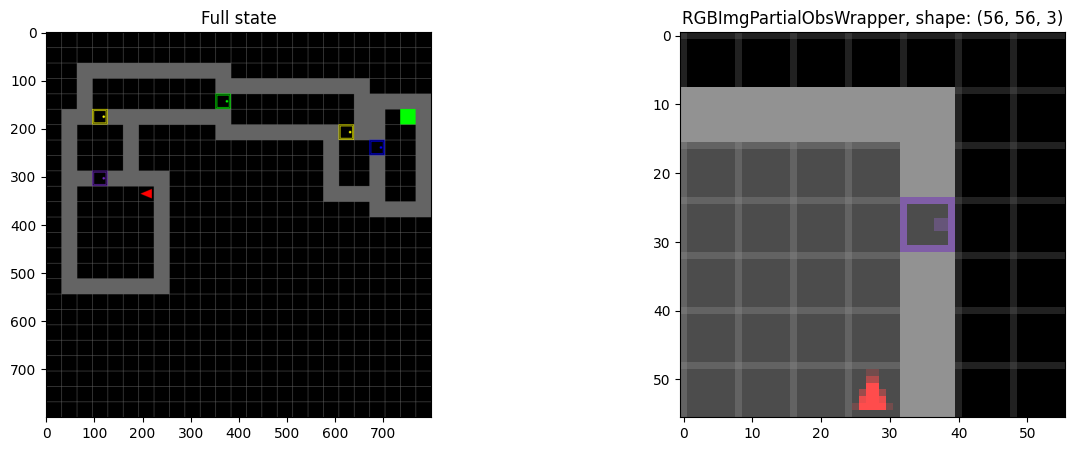

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

### Initializing the smaller environments


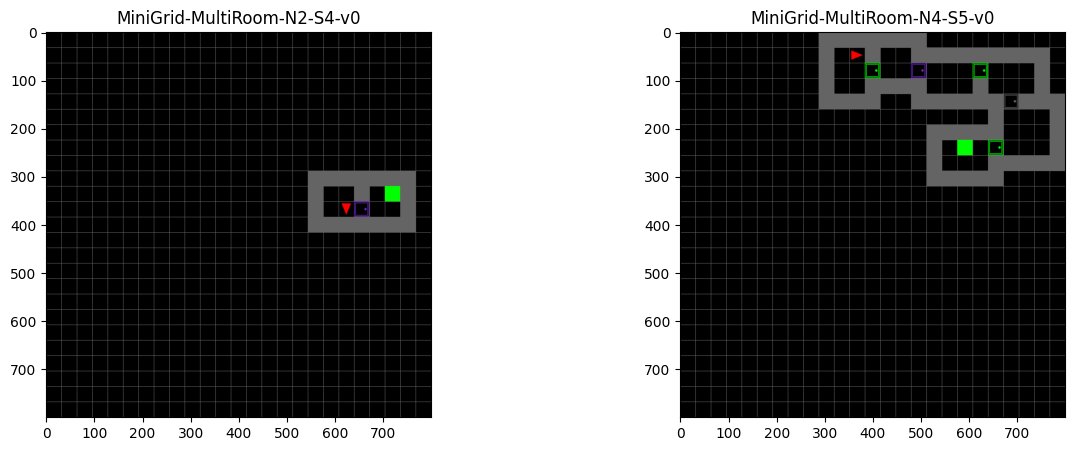

In [16]:
env = gymnasium.make("MiniGrid-MultiRoom-N2-S4-v0", render_mode=render_mode, highlight=highlight)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[0].imshow(env.render())
axs[0].title.set_text(f'MiniGrid-MultiRoom-N2-S4-v0')



env = gymnasium.make("MiniGrid-MultiRoom-N4-S5-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(env.render())
axs[1].title.set_text(f'MiniGrid-MultiRoom-N4-S5-v0')
plt.show()

### Partial Observation Example


In [17]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
# video_filename = '/content/vid_partial.mp4'
video_filename = "C:/Users/ASUS/OneDrive/MSc MLDS/Reinforcement Learning/Projects/final-project/videos/vid.mp4"
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(obs)
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (56, 56) to (64, 64) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


done reward= 0 num_of_steps= 120


# Our Code


--------------------------------------------------
Step 0
Action taken: 2 (Move Forward)


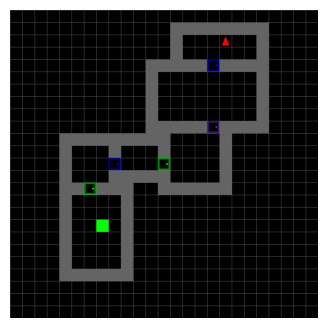

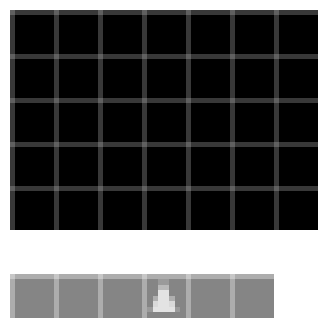

--------------------------------------------------
Step 1
Action taken: 2 (Move Forward)


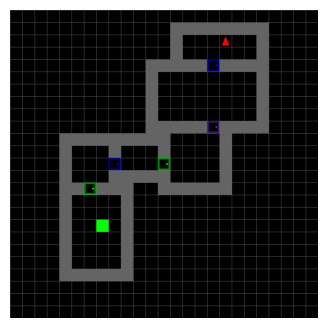

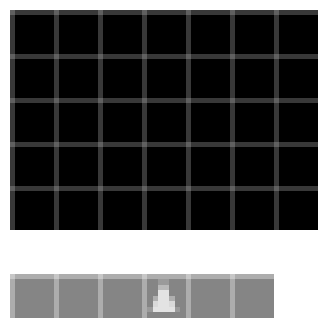

--------------------------------------------------
Step 2
Action taken: 1 (Move Right)


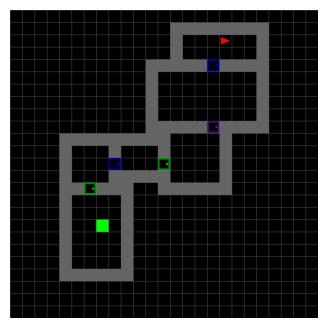

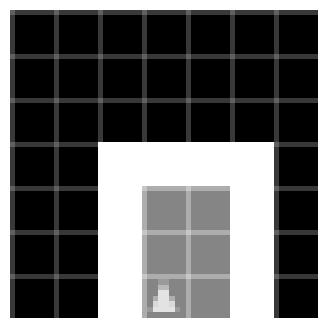

In [18]:
def show_N_steps(env, N, policy=None):
    """
    Runs N steps in the environment, rendering each step.

    Parameters:
        env: The environment instance.
        N (int): Number of steps to execute.
        policy (function): Function that takes obs and returns an action. Defaults to random.
    """
    if policy is None:
        policy = lambda obs: random.choice([0,1,2,5])  # Default to random actions

    obs, _ = env.reset()  # Ensure the environment starts correctly

    for i in range(N):
        print("--------------------------------------------------")
        print(f"Step {i}")

        action = policy(obs)  # Get action from policy
        print(f"Action taken: {action} ({get_action_meaning(action)})")
        obs, reward, done, truncated, info = env.step(action)

        show_full_frame_rgb(env, obs)
        show_partial_greyscale(env, obs)



        if done or truncated:  # Reset if the episode ends
            print("Environment reset!")
            obs, _ = env.reset()
env
# verification
show_N_steps(env, 3)


Environments like MiniGrid MultiRoom require the agent to understand spatial dependencies and remember past observations to make optimal decisions. However, standard observations only provide a single frame, making it difficult for the agent to infer motion, detect doors opening, or track past locations. In order to deal with this, especially to encourage the agent to learn the process of open door and moving to the next room, we will implement FrameStackPreprocess. In addition, this class will convert the observation to greyscale becasue the RGB channels doesn't contribute to the learning process and do downsampling to better efficency and generalization (we don't need the fine details of the environment).


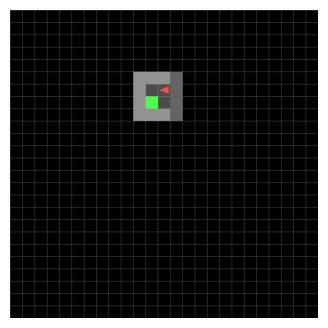

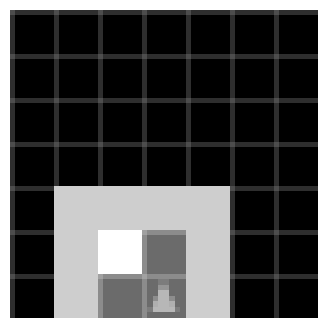

In [19]:
env, obs = create_multiroom_env(1, 4)
img_rgb = show_full_frame_rgb(env, obs)
img_grey = show_partial_greyscale(env, obs)



In [20]:

class FrameStackPreprocess:
    """
    A wrapper for preprocessing and stacking consecutive frames into different channels.
    - Converts RGB frames to grayscale.
    - Normalizes pixel values.
    - Optionally downsamples to a target size.
    - Stacks the last N frames to capture temporal information.

    Parameters:
        num_frames (int): Number of frames to stack.
        img_size (tuple): Original (Height, Width) of frames.
        downsample_size (tuple): Target (Height, Width) after downsampling.
    """

    def __init__(self, num_frames=3, img_size=(56, 56), downsample_size=(14, 14)):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)  # Store last N frames
        self.img_size = img_size  # Ensure all frames have the same shape
        self.downsample_size = downsample_size  # Target downsampling resolution

    def _convert_to_grayscale(self, frame):
        """Converts an RGB frame to grayscale and normalizes it."""
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        frame_gray = frame_gray.astype(np.float32) / 255.0  # Normalize pixel values
        return frame_gray  # Shape: (H, W)

    def _downsample(self, frame):
        """Resizes the frame to the target downsampling size."""
        return cv2.resize(frame, self.downsample_size, interpolation=cv2.INTER_AREA)

    def preprocess(self, frame):
        """Applies grayscale conversion and downsampling."""
        gray_frame = self._convert_to_grayscale(frame)
        return self._downsample(gray_frame)

    def reset(self, first_frame):
        """Initialize the frame stack with copies of the first preprocessed frame."""
        processed_frame = self.preprocess(first_frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)

    def update(self, new_frame):
        """Add a new frame to the stack and remove the oldest."""
        processed_frame = self.preprocess(new_frame)
        self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)
    
    def get_stack(self):
      return torch.tensor(self.frames)


env, obs = create_multiroom_env(1, 50)
frame_stack=FrameStackPreprocess()
frame_stack.reset(obs)
frame_stack.get_stack()



C:\Users\ASUS\AppData\Local\Temp\ipykernel_14300\4067957708.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(self.frames)


tensor([[[0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725,
          0.5725, 0.5725, 0.0620, 0.0324, 0.0620, 0.0324],
         [0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725, 0.5725,
          0.5725, 0.5725, 0.0324, 0.0000, 0.0324, 0.0000],
         [0.3412, 0.3206, 0.3412, 0.3206, 0.3412, 0.3206, 0.3412, 0.3206,
          0.5725, 0.5725, 0.0620, 0.0324, 0.0620, 0.0324],
         [0.3206, 0.2980, 0.3206, 0.2980, 0.3206, 0.2980, 0.3206, 0.2980,
          0.5725, 0.5725, 0.0324, 0.0000, 0.0324, 0.0000],
         [0.3412, 0.3206, 0.3412, 0.3206, 0.3412, 0.3206, 0.3412, 0.3206,
          0.5725, 0.5725, 0.0620, 0.0324, 0.0620, 0.0324],
         [0.3206, 0.2980, 0.3206, 0.2980, 0.3206, 0.2980, 0.3206, 0.2980,
          0.5725, 0.5725, 0.0324, 0.0000, 0.0324, 0.0000],
         [0.3412, 0.3206, 0.3412, 0.3206, 0.3412, 0.3206, 0.3412, 0.3206,
          0.5725, 0.5725, 0.0620, 0.0324, 0.0620, 0.0324],
         [0.3206, 0.2980, 0.3206, 0.2980, 0.3206, 0.2980, 0.3206, 0.2

In [21]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)

To make sure that this fundemental class has no bug and doesn't miss crucial information for learning, we will explicitly check how the stack looks in every state in this simple environment when acting |allways forward" with 1 big room with the reward in the other side.


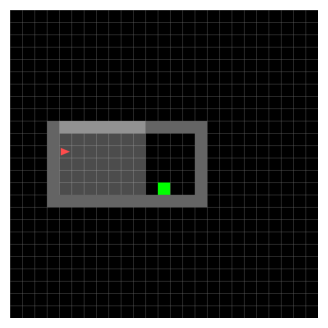

array([[[100, 100, 100],
        [100, 100, 100],
        [100, 100, 100],
        ...,
        [100, 100, 100],
        [100, 100, 100],
        [100, 100, 100]],

       [[100, 100, 100],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[100, 100, 100],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[100, 100, 100],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[100, 100, 100],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[100, 100, 100],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [22]:
env, obs = create_multiroom_env(1, 50, seed=333)
show_full_frame_rgb(env, obs)

Let's have a look on the stack in the 7 first step:


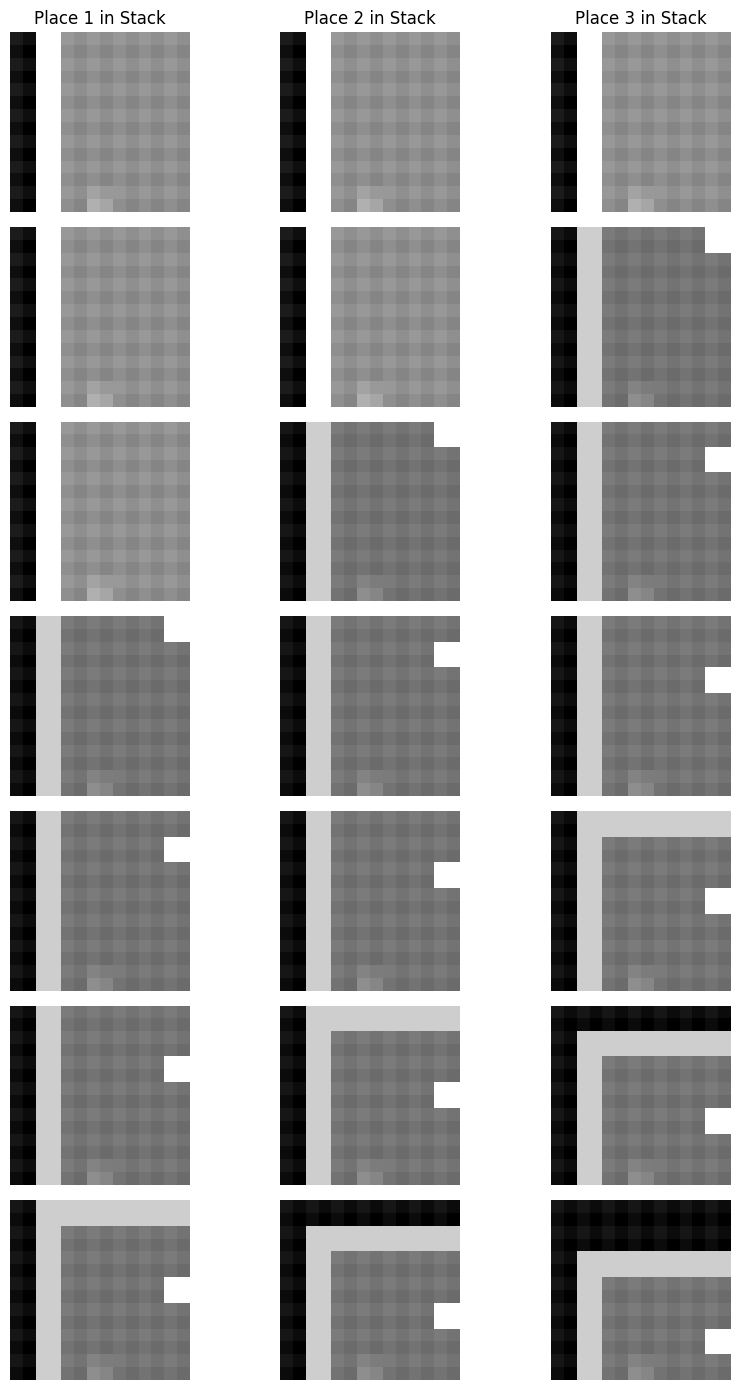

In [23]:
frame_stack = FrameStackPreprocess()
frame_stack.reset(obs)
frame_stack.get_stack().shape

action = 2 # Always move forward

import matplotlib.pyplot as plt

def visualize_frame_stack(env, preprocessor, policy, N=7):
    """
    Runs N iterations, updates FrameStackPreprocess, and directly plots stack positions.

    Parameters:
        env: The MiniGrid environment (already initialized).
        preprocessor: Instance of FrameStackPreprocess.
        policy: Function that returns the action to take.
        N: Number of iterations.

    Returns:
        None (displays plots).
    """
    fig, axes = plt.subplots(N, 3, figsize=(9, 2 * N))  # N rows, 3 columns

    for i in range(N):
        action = policy(env)  # Get action from policy
        obs, _, _, _, _ = env.step(action)  # Step in environment
        stacked_frames = preprocessor.update(obs)  # Update the stack

        for j in range(3):  # 3 stacked frames
            axes[i, j].imshow(stacked_frames[j], cmap="gray")
            axes[i, j].axis("off")
            if i == 0:
                axes[i, j].set_title(f"Place {j+1} in Stack")

    plt.tight_layout()
    plt.show()


visualize_frame_stack(env, frame_stack, lambda env: 2)

As we can see, the stack work well, the transformation of the image still allows to distinct between the tiles of wall, open tile, doors and goal.


## Implementing DQN


### QNet Class


In [27]:
class QNet(nn.Module):
    """
    Q-Network model for our RL task - the NN component for DQN, DDQN and Dueling DQN Agents.
    
    This network consists of:
    - Convolutional layers for feature extraction.
    - Fully connected layers for action selection.
    
    Args:
        input_size (Tuple[int, int, int]): Tuple representing (channels, height, width) of input.
        num_actions (int): Number of possible actions in the environment.

    Example:
        >>> model = DQN((4, 84, 84), num_actions=6)
        >>> x = torch.randn(1, 4, 84, 84)  # Batch of one sample
        >>> output = model(x)
        >>> print(output.shape)  # Expected: (1, 6)
    """

    def __init__(self, input_size: Tuple[int, int, int], num_actions: int) -> None:
        super(QNet, self).__init__()

        # Extract input dimensions
        c, h, w = input_size  # (number of frames, height, width)

        # Convolutional layers for feature extraction
        self.conv = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Compute the flattened size after convolutions
        conv_out_size = self._get_conv_size((c, h, w))

        # Fully connected layers for decision making
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_actions)
        )

    def _get_conv_size(self, shape: Tuple[int, int, int]) -> int:
        """
        Computes the flattened size of the feature maps after convolutional layers.

        Args:
            shape (Tuple[int, int, int]): Input shape (channels, height, width).

        Returns:
            int: Number of elements after flattening.
        """
        with torch.no_grad():
            dummy_tensor = self.conv(torch.zeros(1, *shape))  # Pass a dummy tensor
            return int(np.prod(dummy_tensor.view(-1).size()))  # Compute total elements

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Output Q-values for each action, shape (batch_size, num_actions).
        """
        x = self.conv(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # Apply fully connected layers
        return x



#### Test Qnet


In [ ]:


# Define input size and action space
input_size = (4, 10, 10)  # (channels, height, width) - example
num_actions = 5  # Example number of actions

# Initialize model
model = QNet(input_size, num_actions)

# Generate a test input (batch_size=1)
test_input = torch.ones(1, *input_size)  # All ones, should produce deterministic output

# Forward pass
output = model(test_input)

# Print output
print("Output shape:", output.shape)  # Should be (1, num_actions)
print("Output values:", output.detach().numpy())


Output shape: torch.Size([1, 5])
Output values: [[ 0.00692185  0.05895302  0.04354148 -0.07397626  0.1161212 ]]


In [ ]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Generate a single data point
x = torch.ones(1, *input_size)  # Input
y_target = torch.zeros(1, num_actions)  # Simple target

# Training loop (few iterations)
for i in range(100):
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y_target)
    loss.backward()
    optimizer.step()
    if i % 10 == 0:
        print(f"Iteration {i}: Loss = {loss.item()}")

# Final check: Should decrease if network works
print("Final loss:", loss.item())


Iteration 0: Loss = 0.004875170066952705
Iteration 10: Loss = 0.00019214721396565437
Iteration 20: Loss = 5.319202500686515e-06
Iteration 30: Loss = 1.0846886198123684e-06
Iteration 40: Loss = 6.324159471660096e-07
Iteration 50: Loss = 9.680187673666296e-08
Iteration 60: Loss = 1.8298679904660275e-08
Iteration 70: Loss = 1.0569052300013482e-08
Iteration 80: Loss = 2.155827738548055e-09
Iteration 90: Loss = 9.199597750253474e-10
Final loss: 9.877634266075574e-10


In [ ]:
# Get initial parameters
initial_weights = {name: param.clone() for name, param in model.named_parameters()}

# Perform one training step
optimizer.zero_grad()
y_pred = model(x)
loss = criterion(y_pred, y_target)
loss.backward()
optimizer.step()

# Check if any parameters changed
for name, param in model.named_parameters():
    if torch.equal(param, initial_weights[name]):
        print(f"Warning: {name} did not update!")
    else:
        print(f"Parameter {name} updated correctly.")


Parameter conv.0.weight updated correctly.
Parameter conv.0.bias updated correctly.
Parameter conv.2.weight updated correctly.
Parameter conv.2.bias updated correctly.
Parameter fc.0.weight updated correctly.
Parameter fc.0.bias updated correctly.
Parameter fc.2.weight updated correctly.
Parameter fc.2.bias updated correctly.


### Replay Buffer Class


In [ ]:
import numpy as np
import random
import torch
from collections import deque
from typing import Tuple, List, Deque

class ReplayBuffer:
    """
    A replay buffer for storing and sampling experiences for agents using Q nets.

    This buffer:
    - Stores experiences as (stacked_state, action, reward, stacked_next_state, done).
    - Maintains a deque for storing the last `buffer_size` experiences.
    - Samples complete frame stacks (not individual frames).
    - Provides batch sampling for training deep Q-networks.

    Args:
        buffer_size (int): Maximum number of experiences to store.
        batch_size (int): Number of samples to retrieve per batch.

    Example Usage:
        >>> buffer = ReplayBuffer(buffer_size=10000, batch_size=32)
        >>> buffer.add(stacked_state, action, reward, stacked_next_state, done)
        >>> batch = buffer.sample()
    """

    def __init__(self, buffer_size: int, batch_size: int) -> None:
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory: Deque[Tuple[np.ndarray, int, float, np.ndarray, bool]] = deque(maxlen=buffer_size) # (state, action, reward, next_state, done)

    def add(self, stacked_state: np.ndarray, action: int, reward: float, stacked_next_state: np.ndarray, done: bool) -> None:
        """
        Adds a new experience to the replay buffer - Deque data structure dealls with deleting the old

        Args:
            stacked_state (np.ndarray): Stacked state of shape (num_frames, H, W).
            action (int): Action taken.
            reward (float): Reward received.
            stacked_next_state (np.ndarray): Next stacked state of shape (num_frames, H, W).
            done (bool): Whether the episode ended.
        """
        self.memory.append((stacked_state, action, reward, stacked_next_state, done))

    def sample(self) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Samples a batch of experiences from the replay buffer.

        Returns:
            Tuple of Tensors:
            - states (torch.Tensor): Tensor of shape (batch_size, num_frames, H, W)
            - actions (torch.Tensor): Tensor of shape (batch_size,)
            - rewards (torch.Tensor): Tensor of shape (batch_size,)
            - next_states (torch.Tensor): Tensor of shape (batch_size, num_frames, H, W)
            - dones (torch.Tensor): Tensor of shape (batch_size,)
        """
        if len(self.memory) < self.batch_size:
            raise ValueError("Not enough samples in the buffer to draw a batch.")

        batch = random.sample(self.memory, self.batch_size)

        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to PyTorch tensors
        states_tensor = torch.tensor(np.array(states), dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.int64)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(np.array(next_states), dtype=torch.float32)
        dones_tensor = torch.tensor(dones, dtype=torch.float32)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor

    def __len__(self) -> int:
        """
        Returns the current size of the replay buffer.

        Returns:
            int: Number of experiences stored.
        """
        return len(self.memory)


#### Test ReplayBuffer


In [26]:
import numpy as np
import torch

# Define buffer parameters
buffer_size = 1000
batch_size = 5
num_frames = 3  # Stack 3 frames per state
height, width = 56, 56  # Frame resolution

# Initialize FrameStackPreprocess and ReplayBuffer
frame_stack = FrameStackPreprocess(num_frames=num_frames, img_size=(height, width), downsample_size=(height, width))
buffer = ReplayBuffer(buffer_size=buffer_size, batch_size=batch_size)

# Create a dummy environment-like frame (random grayscale image)
def generate_fake_frame():
    return np.random.randint(0, 256, (height, width, 3), dtype=np.uint8)  # Simulating an RGB frame

# Fill the buffer with experiences
print("Filling Replay Buffer with sample experiences...")

for i in range(100):  # Add 100 experiences
    frame = generate_fake_frame()
    if i == 0:
        stacked_state = frame_stack.reset(frame)  # Initialize stacked frames
    else:
        stacked_state = frame_stack.update(frame)  # Update frame stack

    action = np.random.randint(0, 5)  # Random action (5 actions)
    reward = np.random.uniform(-1, 1)  # Random reward
    done = np.random.choice([True, False], p=[0.1, 0.9])  # Random termination flag (10% chance)

    # Generate the next state
    next_frame = generate_fake_frame()
    stacked_next_state = frame_stack.update(next_frame)

    # Store experience
    buffer.add(stacked_state, action, reward, stacked_next_state, done)

# Check buffer length
print(f"Replay Buffer filled. Current size: {len(buffer)}")

# Sample a batch
print("\nSampling from Replay Buffer...")
states, actions, rewards, next_states, dones = buffer.sample()

# **Verification Tests**
print("\nVerifying sampled data...")

# 1. Check Tensor shapes
assert states.shape == (batch_size, num_frames, height, width), f"Expected states shape {(batch_size, num_frames, height, width)}, got {states.shape}"
assert next_states.shape == (batch_size, num_frames, height, width), f"Expected next_states shape {(batch_size, num_frames, height, width)}, got {next_states.shape}"
assert actions.shape == (batch_size,), f"Expected actions shape {(batch_size,)}, got {actions.shape}"
assert rewards.shape == (batch_size,), f"Expected rewards shape {(batch_size,)}, got {rewards.shape}"
assert dones.shape == (batch_size,), f"Expected dones shape {(batch_size,)}, got {dones.shape}"

print("✔ Passed shape verification.")

# 2. Check that all values are within expected ranges
assert torch.all(actions >= 0) and torch.all(actions < 5), "✔ Action values out of range!"
assert torch.all(rewards >= -1) and torch.all(rewards <= 1), "✔ Reward values out of range!"
assert torch.all((dones == 0) | (dones == 1)), "✔ Done values must be 0 or 1!"

print("✔ Passed value verification.")

# 3. Check that state transitions are reasonable
for i in range(batch_size):
    assert not torch.equal(states[i], next_states[i]), "✔ Sampled states and next states should not be identical!"

print("✔ Passed state transition verification.")

print("\n🎉 Replay Buffer Verification Complete: All Tests Passed!")


Filling Replay Buffer with sample experiences...
Replay Buffer filled. Current size: 100

Sampling from Replay Buffer...

Verifying sampled data...
✔ Passed shape verification.
✔ Passed value verification.
✔ Passed state transition verification.

🎉 Replay Buffer Verification Complete: All Tests Passed!


In [ ]:
dqn_agent = DQNAgent(input_size=(3,7,7), buffer_capacity=64)
fram_stack = FrameStackPreprocess(num_frames=3, img_size=(56, 56), downsample_size=(14, 14))
video_filename = Path.joinpath(WORK_DIR, "videos/vid.mp4")
truncated = False
obs, _ = env.reset()
fram_stack.reset(obs)
done = False
total_reward = 0
step = 0
action = dqn_agent.select_action(fram_stack)
loss, q_value, grad = dqn_agent.update()
obs, reward, done, truncated  , _ = env.step(action)


In [ ]:
env, obs = create_multiroom_env(num_rooms=1,max_room_size= 8)

env.unwrapped.max_steps=100
print(env.unwrapped.max_steps)

100


### Agent Class


In [ ]:
class BaseAgent(ABC):
    """
    Abstract base class for all Deep Q-Network (DQN)-based agents.

    This class provides:
    - Initialization of neural networks (policy & target).
    - Common hyperparameters for training (gamma, learning rate, epsilon, etc.).
    - A method to update the target network at fixed intervals.
    - A replay buffer for experience storage.

    Subclasses must implement:
    - `_build_model()` → Defines the neural network.
    - `select_action()` → Chooses an action using an epsilon-greedy strategy.
    - `train_step()` → Implements the training logic.

    """
    def __init__(
        self,
        frames_in_stack: int,
        downsample_size: Tuple[int, int],
        actions_space: List[int],
        gamma: float,
        lr: float,
        epsilon: float,
        target_update_freq: int
    ) -> None:
        """
        Initializes the BaseAgent with common RL hyperparameters.

        Args:
            state_dim (Tuple[int, int, int]): State dimensions (num_frames, height, width).
            actions_space (list): space of (valid) actions 
                0 - Turn left
                1 - Turn right
                2 - Move Forward
                5 - Toggle (open doors/close doors)
            gamma (float): Discount factor for future rewards.
            lr (float): Learning rate.
            epsilon (float): Exploration probability.
            target_update_freq (int): Number of steps between target network updates.
        """
        self.num_actions = num_actions
        self.gamma = gamma
        self.lr = lr
        self.epsilon = epsilon
        self.target_update_freq = target_update_freq

        # Set device (GPU if available, else CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize policy and target networks
        self.policy_net = self._build_model().to(self.device)
        self.target_net = self._build_model().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())  # Synchronize initial weights
        self.target_net.eval()  # Target network does not require gradients

        # Optimizer for training the policy network
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

        # Replay buffer to store past experiences
        self.memory = ReplayBuffer(buffer_size=10_000, batch_size=32)

        # Training step counter
        self.train_step_count = 0

    @abstractmethod
    def _build_model(self) -> nn.Module:
        """
        Defines the neural network architecture.

        This method must be implemented in subclasses to create a specific DQN model.

        Returns:
            nn.Module: The initialized neural network.
        """
        pass

    @abstractmethod
    def select_action(self, state: np.ndarray) -> int:
        """
        Selects an action based on the given state using an epsilon-greedy policy.

        This method must be implemented in subclasses.

        Args:
            state (np.ndarray): The current environment state.

        Returns:
            int: The chosen action.
        """
        pass

    @abstractmethod
    def train_step(self) -> None:
        """
        Performs a single training step.

        This method must be implemented in subclasses and should include:
        - Sampling experiences from the replay buffer.
        - Computing the Q-learning target values.
        - Optimizing the policy network.
        - Updating the target network when required.
        """
        pass

    def update_target_network(self) -> None:
        """
        Copies weights from the policy network to the target network at fixed intervals.

        The update happens every `target_update_freq` training steps.
        """
        if self.train_step_count % self.target_update_freq == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())


In [ ]:

class FrameStackPreprocess:
    """
    A wrapper for preprocessing and stacking consecutive frames into different channels.
    - Converts RGB frames to grayscale.
    - Normalizes pixel values.
    - Optionally downsamples to a target size.
    - Stacks the last N frames to capture temporal information.

    Parameters:
        num_frames (int): Number of frames to stack.
        img_size (tuple): Original (Height, Width) of frames.
        downsample_size (tuple): Target (Height, Width) after downsampling.
    """

    def __init__(self, num_frames=3, img_size=(56, 56), downsample_size=(14, 14)):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)  # Store last N frames
        self.img_size = img_size  # Ensure all frames have the same shape
        self.downsample_size = downsample_size  # Target downsampling resolution

    def _convert_to_grayscale(self, frame):
        """Converts an RGB frame to grayscale and normalizes it."""
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        frame_gray = frame_gray.astype(np.float32) / 255.0  # Normalize pixel values
        return frame_gray  # Shape: (H, W)

    def _downsample(self, frame):
        """Resizes the frame to the target downsampling size."""
        return cv2.resize(frame, self.downsample_size, interpolation=cv2.INTER_AREA)

    def preprocess(self, frame):
        """Applies grayscale conversion and downsampling."""
        gray_frame = self._convert_to_grayscale(frame)
        return self._downsample(gray_frame)

    def reset(self, first_frame):
        """Initialize the frame stack with copies of the first preprocessed frame."""
        processed_frame = self.preprocess(first_frame)
        for _ in range(self.num_frames):
            self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)

    def update(self, new_frame):
        """Add a new frame to the stack and remove the oldest."""
        processed_frame = self.preprocess(new_frame)
        self.frames.append(processed_frame)
        return np.stack(self.frames, axis=0)  # Shape: (num_frames, H, W)
    
    def get_stack(self):
      return torch.tensor(self.frames)


env, obs = create_multiroom_env(1, 50)
frame_stack=FrameStackPreprocess()
frame_stack.reset(obs)
frame_stack.get_stack()

